In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple


def debug_save(img, path):
    cv2.imwrite(f"debug/{path}.png", img)

def normalize_line(line) -> None:
    line = line[0]

    if line[0] < 0:
        line[0] *= -1
        line[1] += np.pi

def are_duplicates(line_a, line_b, rho_threshold, theta_threshold):
    rho_a, theta_a = line_a[0]
    rho_b, theta_b = line_b[0]

    if rho_a < 0:
        rho_a = -rho_a
        theta_a += np.pi

    if rho_b < 0:
        rho_b = -rho_b
        theta_b += np.pi

    rho_diff = (theta_a - theta_b + np.pi) % (2 * np.pi) - np.pi

    if abs(rho_diff) < theta_threshold and abs(rho_a - rho_b) < rho_threshold:
        return True
    else:
        return False


def is_axis_aligned(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta <= np.pi or np.pi/2 - threshold <= theta <= np.pi/2 + threshold:
        return True
    else:
        return False


def auto_canny(image, sigma=0.33):
    #bluring the image
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged


# def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
#
#     if brightness != 0:
#         if brightness > 0:
#             shadow = brightness
#             highlight = 255
#         else:
#             shadow = 0
#             highlight = 255 + brightness
#         alpha_b = (highlight - shadow)/255
#         gamma_b = shadow
#
#         buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
#     else:
#         buf = input_img.copy()
#
#     if contrast != 0:
#         f = 131*(contrast + 127)/(127*(131-contrast))
#         alpha_c = f
#         gamma_c = 127*(1-f)
#
#         buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)
#
#     return buf


def is_horizontal(line, threshold):
    rho, theta = line[0]

    if np.pi/2 - threshold <= theta % np.pi <= np.pi/2 + threshold:
        return True
    else:
        return False


def is_vertical(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta % np.pi <= np.pi:
        return True
    else:
        return False


def simplify_image(img, limit, grid, iters):
        """Simplify image using CLAHE algorithm (adaptive histogram
        equalization)."""
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        img = cv2.medianBlur(img, 5)
        # img = cv2.GaussianBlur(img, (5, 5), 1)

        for _ in range(iters):
            img = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid).apply(
                img)
        debug_save(img, "slid_clahe_@1")
        if limit != 0:
            kernel = np.ones((10, 10), np.uint8)
            img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
            debug_save(img, "slid_clahe_@2")
        return img


def find_edges(img):
    edges = auto_canny(img)
    # edges = cv2.GaussianBlur(edges, (5, 5), 2)
    return edges


def find_lines(edges: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 30)
    if lines is None:
        return np.zeros([0, 1, 2]), np.zeros([0, 1, 2])
    lines = lines[:50]

    for line in lines:
        normalize_line(line)

    lines = np.array([
        line for index, line in enumerate(lines) if
        all([not are_duplicates(x, line, 10, 5*np.pi/180) for x in lines[:index]])
    ])

    h_lines = np.array([line for line in lines if is_horizontal(line, 15*np.pi/180)])
    v_lines = np.array([line for line in lines if is_vertical(line, 15*np.pi/180)])

    return h_lines, v_lines


def overlay_lines(img, lines, color):
    img = img.copy()

    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1,y1), (x2,y2), color, 1)

    return img

In [72]:
# img = cv2.imread("test8.jpg", cv2.IMREAD_COLOR)
# img = cv2.resize(img, (480, 480))
#
# clahe_settings = [[3, (2, 6), 5],  # @1
#                   [3, (6, 2), 5],  # @2
#                   [3, (3, 3), 5],  # @3
#                   [0, (0, 0), 0]]  # EE
#
# plt.figure(figsize = (10,10))
# plt.imshow(img)
# plt.show()
#
#
# segments = []
# i = 0
# for key, arr in enumerate(clahe_settings):
#     tmp = simplify_image(img, limit=arr[0], grid=arr[1], iters=arr[2])
#
#     plt.figure(figsize = (10,10))
#     plt.imshow(tmp)
#     plt.show()

In [2]:
def intersection(line1, line2):

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]

    # if lines are almost parallel, we skip them
    if abs(theta1 - theta2) < 0.001:
        return None

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]

def are_intersecting_in_range(line1, line2, xy_min, xy_max):
    intersect = intersection(line1, line2)
    if intersect is None:
        return False

    return xy_min[0] < intersect[0] < xy_max[0] and xy_min[1] < intersect[1] < xy_max[1]

def segmented_intersections(h_lines, v_lines):
    intersections = []
    for h_line in h_lines:
        for v_line in v_lines:
            # horizontal lines and vertical lines always intersect so no None check
            intersections.append(intersection(h_line, v_line))

    return intersections

def overlay_markers(img, points):
    img = img.copy()
    for x, y in points:
        cv2.drawMarker(img, (x, y), 20, thickness = 5)
    return img


In [14]:
import math

def average_angles(angles):
    """Average (mean) of angles

    Return the average of an input sequence of angles. The result is between
    ``0`` and ``2 * math.pi``.
    If the average is not defined (e.g. ``average_angles([0, math.pi]))``,
    a ``ValueError`` is raised.
    """

    x = sum(math.cos(a) for a in angles)
    y = sum(math.sin(a) for a in angles)

    if x == 0 and y == 0:
        raise ValueError(
            "The angle average of the inputs is undefined: %r" % angles)

    # To get outputs from -pi to +pi, delete everything but math.atan2() here.
    return math.fmod(math.atan2(y, x) + 2 * math.pi, 2 * math.pi)


def subtract_angles(lhs, rhs):
    return math.fmod((lhs - rhs) + math.pi * 3, 2 * math.pi) - math.pi


# oboże kurwa moje oczy, numpy array w liście jest jakiś niedojebany
def remove_intersecting_lines(lines):
    if lines.shape == 0 or lines.shape[0] == 0:
        return lines

    average_theta = average_angles([line[0][1] for line in lines])

    incorrect_lines_indexes = []

    for index, line in enumerate(lines):
        if index in incorrect_lines_indexes:
            continue

        intersecting_lines_indexes = [index]
        for other_line_index in range(index+1, len(lines)):
            other_line = lines[other_line_index]
            if are_intersecting_in_range(line, other_line, (-256, -256), (768, 768)):
                intersecting_lines_indexes.append(other_line_index)

        min_angle_diff = min([abs(subtract_angles(average_theta, lines[i][0][1])) for i in intersecting_lines_indexes])

        for i in intersecting_lines_indexes:
            if abs(subtract_angles(average_theta, lines[i][0][1])) > min_angle_diff:
                incorrect_lines_indexes.append(i)

    return [line for index, line in enumerate(lines) if index not in incorrect_lines_indexes]


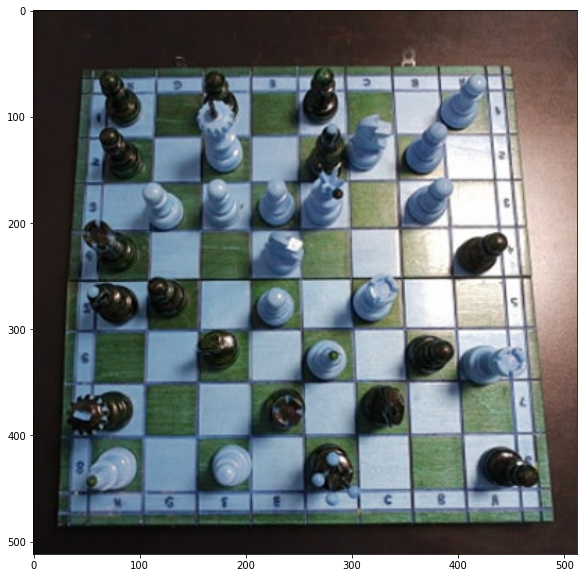

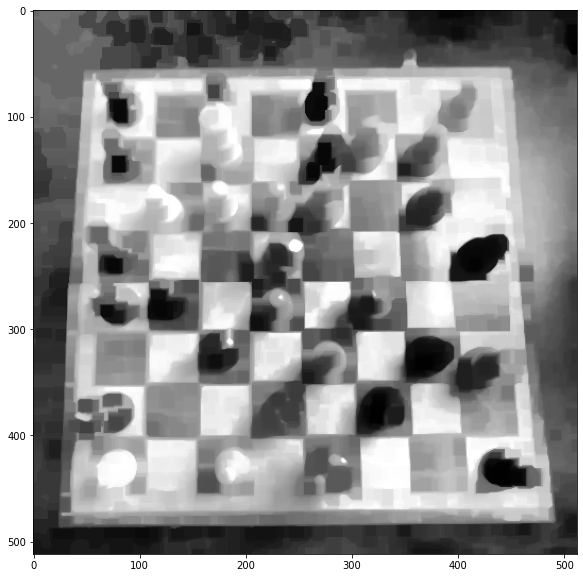

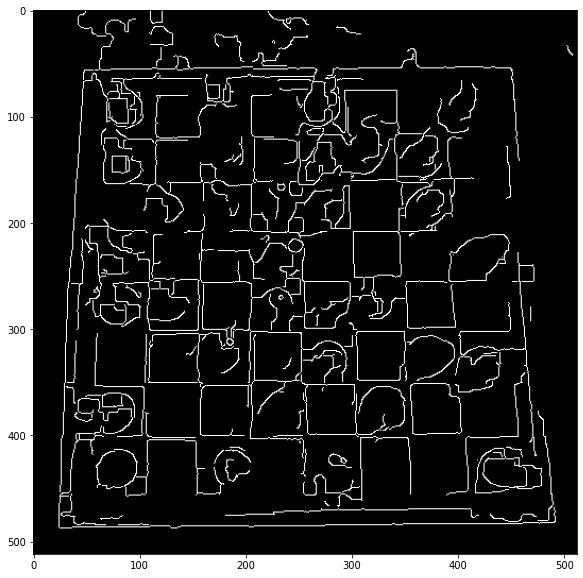

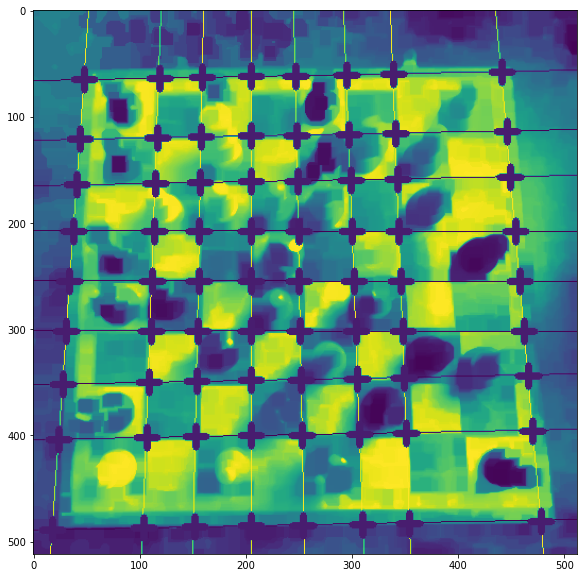

[array([[489.      ,   1.553343]], dtype=float32),
 array([[255.       ,   1.5707964]], dtype=float32),
 array([[165.      ,   1.553343]], dtype=float32),
 array([[404.      ,   1.553343]], dtype=float32),
 array([[66.      ,  1.553343]], dtype=float32),
 array([[208.       ,   1.5707964]], dtype=float32),
 array([[302.       ,   1.5707964]], dtype=float32),
 array([[122.      ,   1.553343]], dtype=float32),
 array([[352.      ,   1.553343]], dtype=float32)]

In [4]:
img = cv2.imread("test7.jpg", cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

img = simplify_image(img, limit=3, grid=(3, 3), iters=5)

plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')
plt.show()

overlayed_frame = img.copy()

edges = find_edges(img)
h_lines, v_lines = find_lines(edges)

h_lines = remove_intersecting_lines(h_lines)
v_lines = remove_intersecting_lines(v_lines)

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

intersections = np.array(segmented_intersections(h_lines, v_lines))

overlayed_frame = overlay_lines(overlayed_frame, v_lines, (255, 0, 0))
overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 255, 0))
overlayed_frame = overlay_markers(overlayed_frame, intersections)

plt.figure(figsize = (10,10))
plt.imshow(overlayed_frame)
plt.show()

h_lines

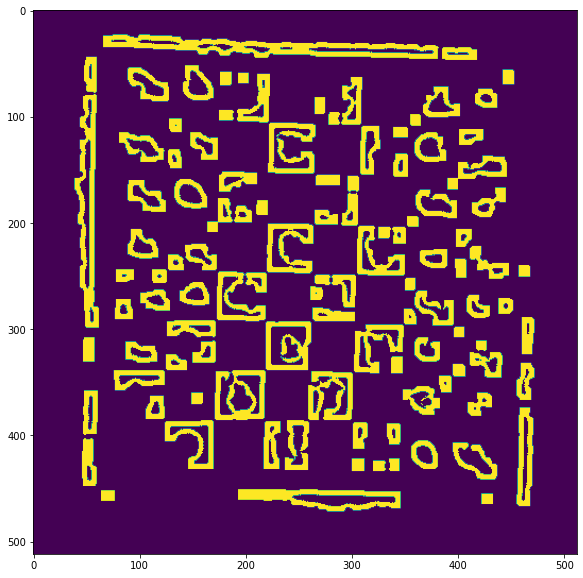

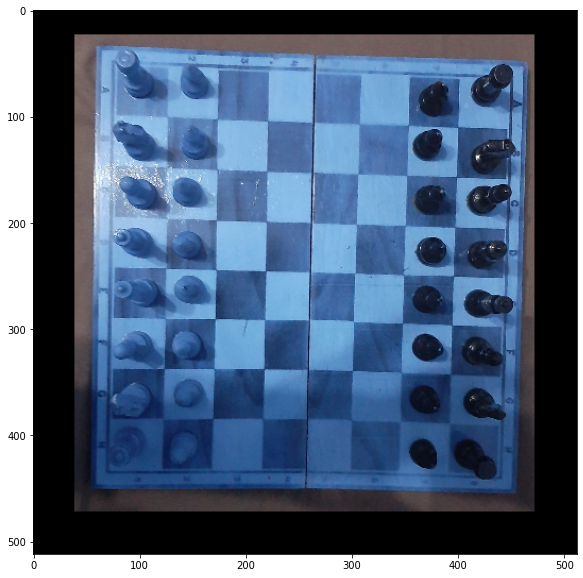

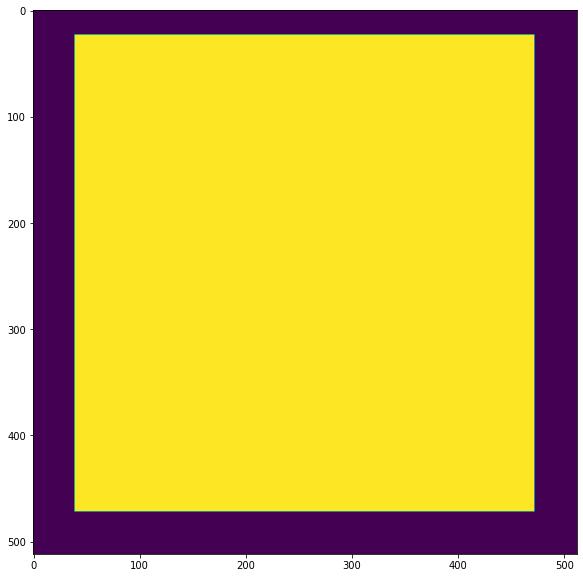

In [164]:
# BEZUŻYTECZNY KAWAŁEK ZIEMNIAKA

# def mask_largest_contour(img):
#     img = img.copy()
#     blur = cv2.GaussianBlur(img, (11,11), 0)
#
#     thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 5, 2)
#     # thresh = cv2.dilate(thresh, np.ones([3, 3]), iterations=2)
#     # thresh = cv2.erode(thresh, np.ones([3, 3]), iterations=2)
#
#     # contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#
#     plt.figure(figsize = (10,10))
#     plt.imshow(thresh)
#     plt.show()
#
#     # contour = max(contours, key=cv2.contourArea)
#
#     mask = np.zeros_like(img)
#     # cv2.drawContours(mask, [contour], 0, color=255, thickness=-1)
#     # cv2.drawContours(mask, [contour], 0, color=0, thickness=2)
#
#     rect = cv2.minAreaRect(cv2.findNonZero(thresh))
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)
#     cv2.drawContours(mask,[box],0, 255,-1)
#
#     return mask
#
#
#
# img = cv2.imread("test8.jpg", cv2.IMREAD_COLOR)
# img = cv2.resize(img, (512, 512))
# original_img = img.copy()
#
# img = simplify_image(img, limit=3, grid=(3, 3), iters=5)
# mask = mask_largest_contour(img)
#
# plt.figure(figsize = (10,10))
# plt.imshow(original_img & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))
# plt.show()
#
# plt.figure(figsize = (10,10))
# plt.imshow(mask)
# plt.show()

In [20]:
import cv2
import numpy as np


def process_samera_feed():
    # Create a VideoCapture object

    try:
        cap = cv2.VideoCapture(0)

        # Check if camera opened successfully
        if (cap.isOpened() == False):
            print("Unable to read camera feed")
            cap.release()
            return

        # Default resolutions of the frame are obtained.The default resolutions are system dependent.
        # We convert the resolutions from float to integer.
        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        frame_size = min([frame_width, frame_height])

        # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
        # out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (512, 512))

        while True:
            ret, frame = cap.read()

            frame = frame[(frame_height - frame_size)//2 : frame_height - (frame_height - frame_size)//2, (frame_width - frame_size)//2 : frame_width - (frame_width - frame_size)//2]
            frame = cv2.resize(frame, (512, 512))
            original_frame = frame.copy()
            overlayed_frame = frame.copy()

            frame = simplify_image(frame, limit=3, grid=(2, 6), iters=5)

            edges = find_edges(frame)
            h_lines, v_lines = find_lines(edges)

            h_lines = remove_intersecting_lines(h_lines)
            v_lines = remove_intersecting_lines(v_lines)

            overlayed_frame = overlay_lines(overlayed_frame, v_lines, (255, 0, 0))
            overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 255, 0))

            intersections = np.array(segmented_intersections(h_lines, v_lines))

            overlayed_frame = overlay_markers(overlayed_frame, intersections)

            if ret == True:
                # out.write(frame)
                # print(overlayed_frame.shape)
                # cv2.imshow('markers', overlayed_frame)
                # cv2.imshow('original', original_frame)
                color_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                concatinated_images = np.concatenate([original_frame, color_frame, overlayed_frame], axis=1)

                cv2.imshow('processed', concatinated_images)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
    finally:
        cap.release()
        # out.release()
        cv2.destroyAllWindows()


process_samera_feed()

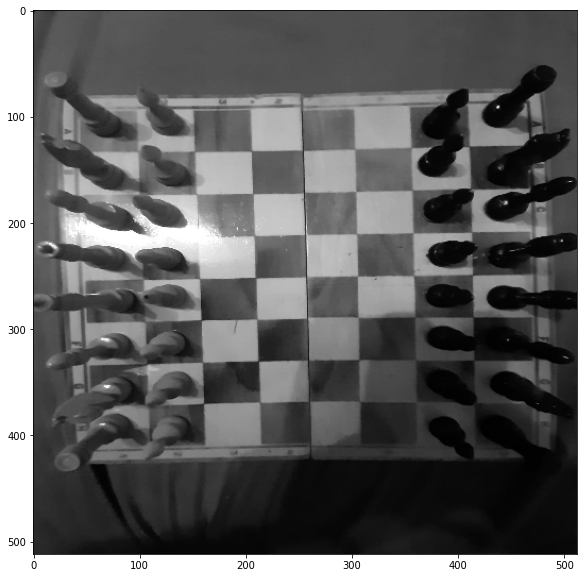

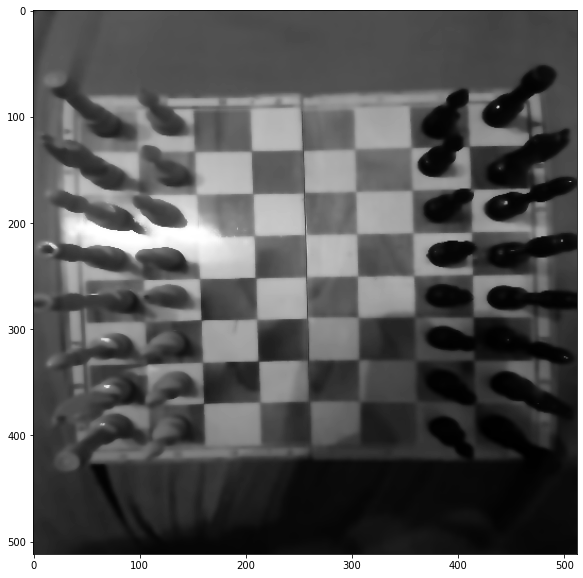

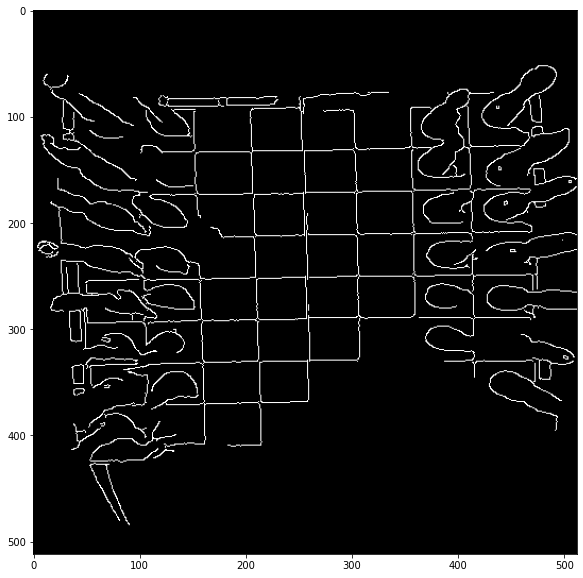

In [4]:
img = cv2.imread("test4.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))

# img = ((img/255.0)**2 * 255).astype(np.uint8)

# edges = cv2.Canny(img, 50,200, apertureSize = 3)

# Smoothing without removing edges.
gray_filtered = cv2.bilateralFilter(img, 7, 50, 50)

# Applying the canny filter
# edges = cv2.Canny(gray, 60, 120)
edges = cv2.Canny(gray_filtered, 50, 200)

# kernel = np.ones((5,5), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1) 
# edges = cv2.erode(edges, kernel, iterations=1) 

plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(gray_filtered, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

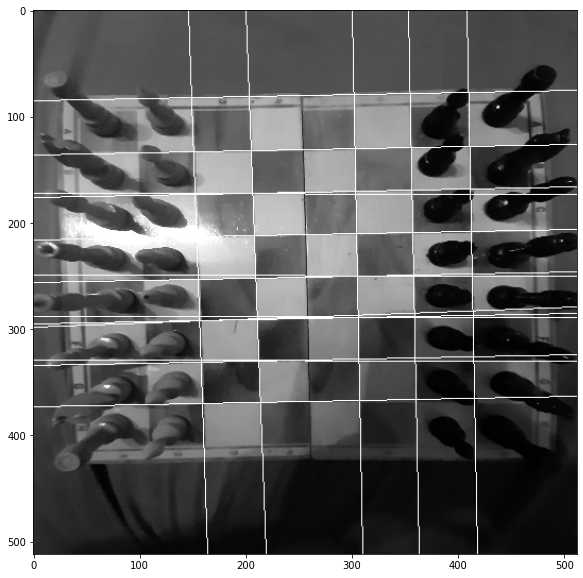

(18, 1, 2)

In [5]:
# bg = np.zeros_like(edges)

# _, thresh = cv2.threshold(edges,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

imgcopy = img.copy()

lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 100)

lines = lines[:100]

for line in lines:
    for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(imgcopy,(x1,y1),(x2,y2),255,1)

plt.figure(figsize = (10,10))
plt.imshow(imgcopy, cmap='gray')
plt.show()

lines.shape

# Auto canny + Blur + HoughLines

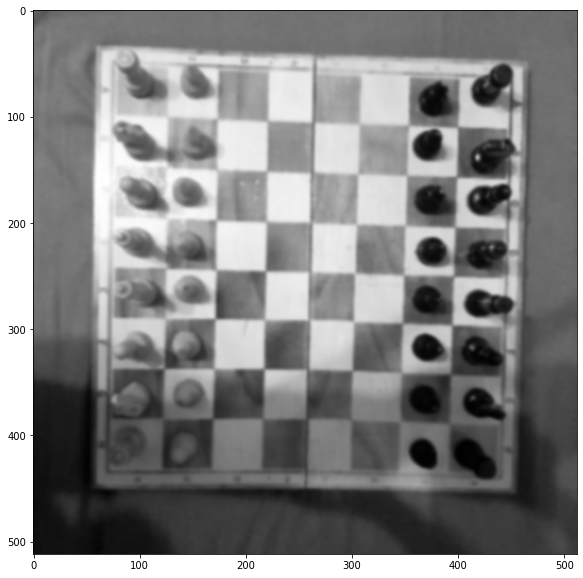

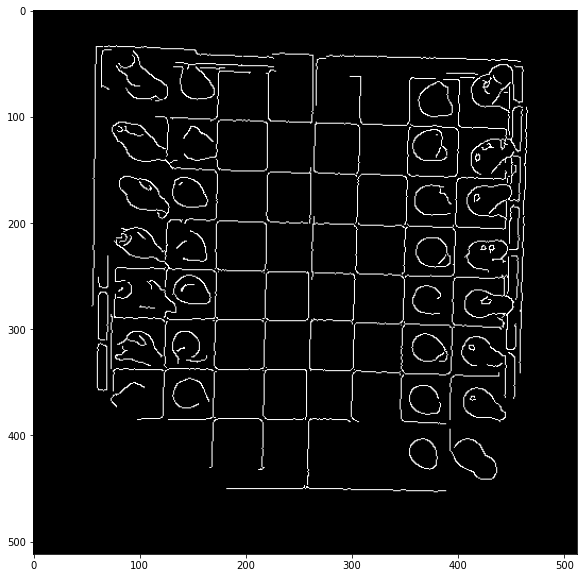

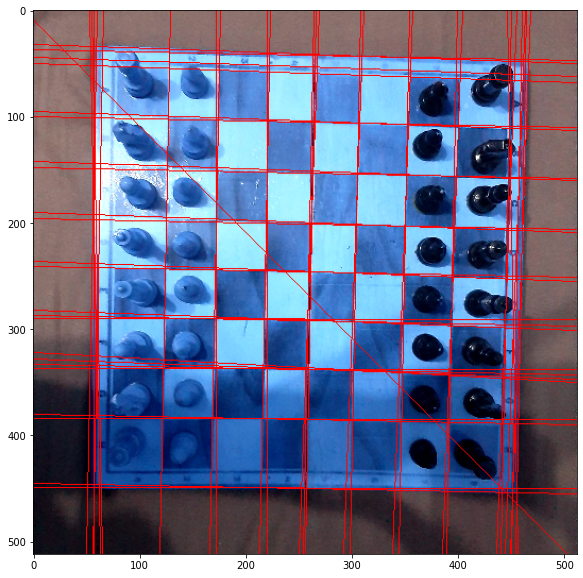

In [6]:
import cv2
import numpy as np


img = cv2.imread('test8.jpg', cv2.IMREAD_COLOR)

img = apply_brightness_contrast(img, 32, 32)

img = cv2.resize(img, (512, 512))
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = auto_canny(blurred)

# kernel = np.ones((5,5), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=2) 

lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 50)

lines = lines[:50]

for line in lines:
    for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),255,1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

(50, 1, 2)
(22, 1, 2)


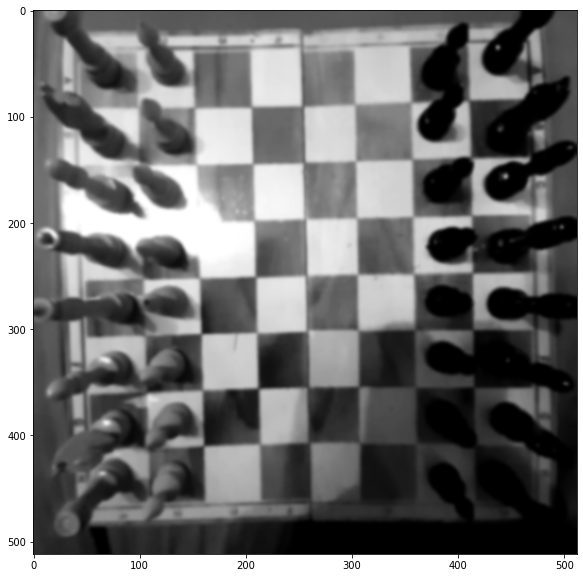

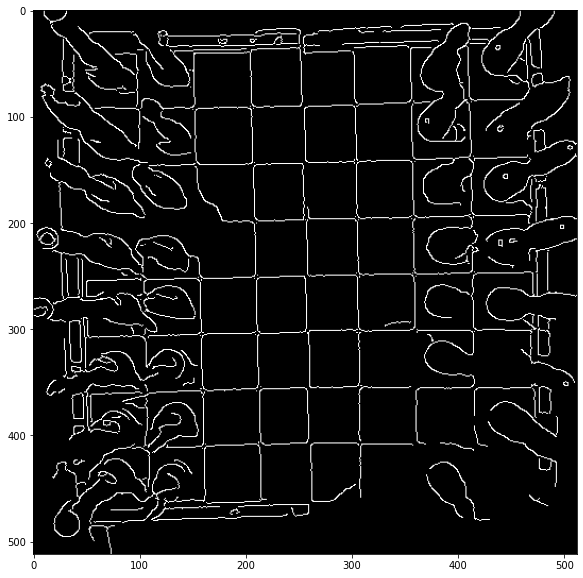

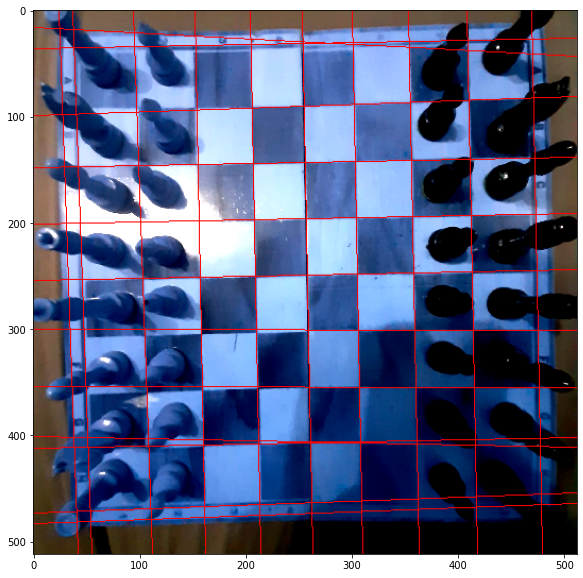

In [32]:
import cv2
import numpy as np

img = cv2.imread('test6.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))
img = apply_brightness_contrast(img, 32, 32)
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = auto_canny(blurred)

# kernel = np.ones((3,3), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=2) 

lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 50)

lines = lines[:50]

print(lines.shape)

lines = np.array([
    line for index, line in enumerate(lines) if 
    all([not are_duplicates(x, line, 10, 10*np.pi/180) for x in lines[:index]])
    and is_axis_aligned(line, 10*np.pi/180)
])

print(lines.shape)


for line in lines:
    for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))

            cv2.line(img,(x1,y1),(x2,y2),255,1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()


# Auto canny + Blur + HoughLinesP

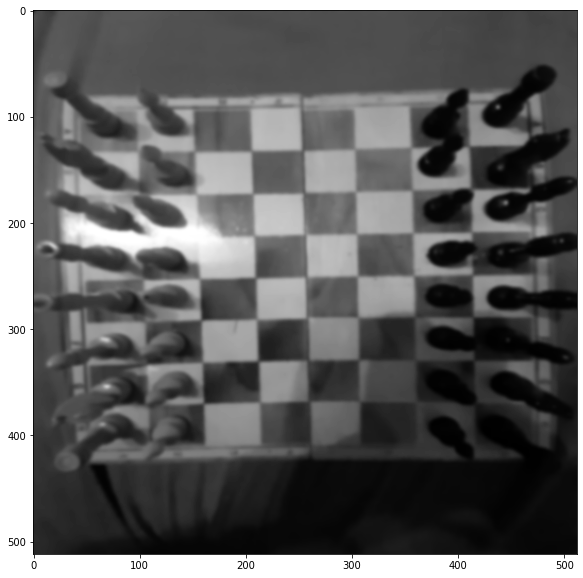

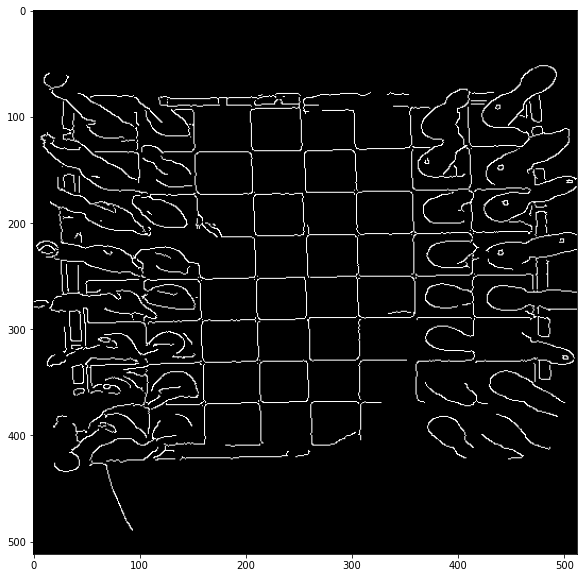

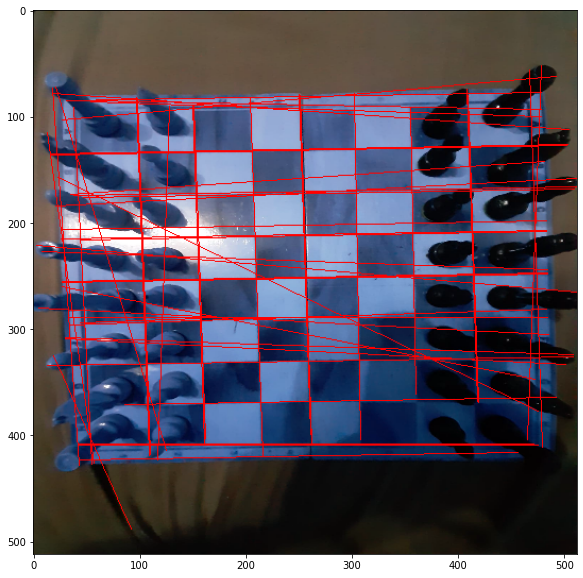

In [8]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged


import cv2
import numpy as np

img = cv2.imread('test4.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edges = auto_canny(blurred)

kernel = np.ones((3,3), np.uint8) 
# edges = cv2.dilate(edges, kernel, iterations=1)
# edges = cv2.erode(edges, kernel, iterations=1) 

lines = cv2.HoughLinesP(edges, rho = 1,theta = 1*np.pi/180,threshold = 20, minLineLength=20, maxLineGap=150)
for line in lines[:50]:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

# Manual canny + Blur + HoughLines

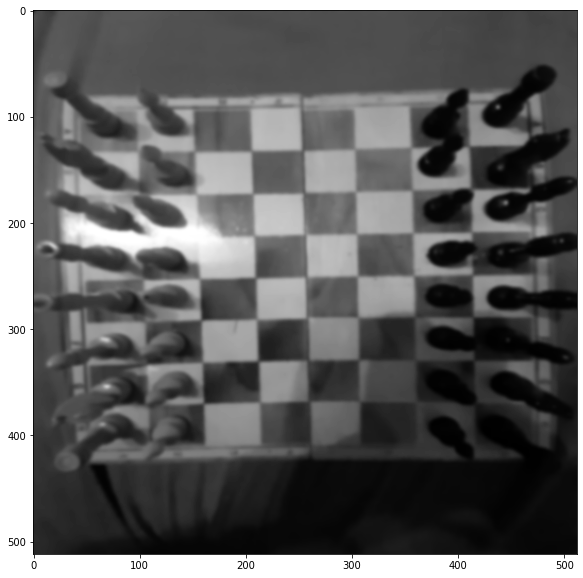

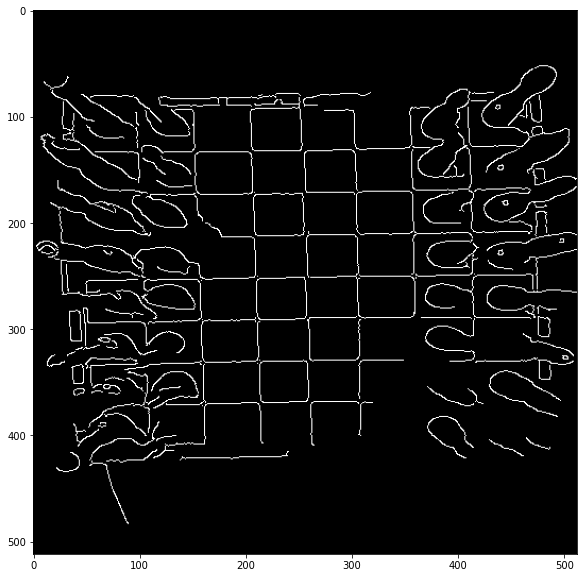

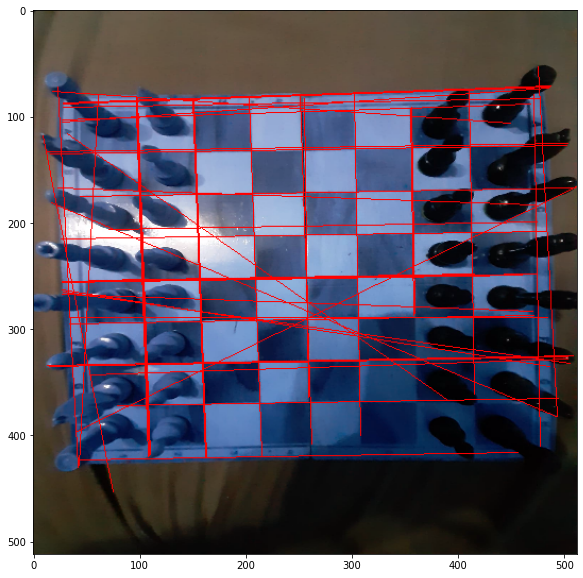

In [9]:
import cv2
import numpy as np

img = cv2.imread('test4.jpg', cv2.IMREAD_COLOR)
img = cv2.resize(img, (512, 512))
# Convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (7, 7), 0)

# Applying the canny filter
edges = cv2.Canny(blurred, 60, 120)

# Detect points that form a line
lines = cv2.HoughLinesP(edges, rho = 1,theta = 1*np.pi/180,threshold = 50, minLineLength=10, maxLineGap=500)
# Draw lines on the image
for line in lines[:50]:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)


plt.figure(figsize = (10,10))
plt.imshow(blurred, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(edges, cmap='gray')
plt.show()

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()